In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
date_str = datetime.datetime.now().strftime("%Y-%m-%d")

# Read the data file and display
train = pd.read_json('WebData/stayz_nsw_extract_' + date_str + '.json')

train = train.reset_index(drop=True)
train = train.set_index('property_id')

train.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9080772,3,4,8,Centrally located to town this 4 bedroom 2 sto...,10,Gardenview Jindabyne,350,-36.418800,148.62100,House,17,2018-03-08 16:47:06,SW,219,356,https://www.stayz.com.au//accommodation/nsw/sn...
9117434,4,6,11,When you just want to get away from it all and...,20,"Wallis Lakehouse, Pacific Palms",537,-32.328000,152.48300,House,98,2018-03-08 16:47:06,NE,33,221,https://www.stayz.com.au//accommodation/nsw/no...
9069770,1,3,3,Enjoy this stunningly designed and superbly ap...,6,Culburra Retreat - located at Culburra Beach,253,-34.928154,150.76508,House,32,2018-03-08 16:47:06,S,199,111,https://www.stayz.com.au//accommodation/nsw/so...
9071475,1,2,5,Nestled high in a canopy of gum trees with stu...,5,Braeside Cabin Retreat,121,-33.640610,150.29774,Cabin,55,2018-03-08 16:47:06,NW,295,90,https://www.stayz.com.au//accommodation/nsw/bl...
9006125,2,2,6,Affordable Ski Luxury - Thredbo Australia,6,Talgara 3 Ski Chalet Thredbo,259,-36.505066,148.30551,Chalet,8,2018-03-08 16:47:06,SW,222,382,https://www.stayz.com.au//accommodation/nsw/sn...


In [3]:
# If the initial price is zero, set to NaN so it doesnt affect the statistics
train.loc[train['init_price'] == 0,'init_price'] = np.nan

train.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,18005.000000,18005.000000,18005.000000,18005.000000,17572.000000,18005.000000,18005.000000,18005.000000,18005.000000,18005.000000
mean,1.848542,2.966121,4.303471,6.663649,317.592932,-33.179410,151.279712,5.704860,110.206998,224.324021
std,1.149847,1.574156,3.241123,3.852702,2373.666334,2.525481,4.578012,12.403978,106.821165,329.724070
min,0.000000,0.000000,0.000000,1.000000,1.000000,-41.453060,-100.945830,0.000000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,4.000000,143.000000,-34.775000,150.545970,0.000000,22.000000,78.000000
50%,2.000000,3.000000,4.000000,6.000000,209.000000,-33.607300,151.271100,1.000000,32.000000,162.000000
75%,2.000000,4.000000,5.000000,8.000000,330.000000,-32.343130,152.428130,5.000000,203.000000,339.000000
max,41.000000,41.000000,100.000000,120.000000,312197.000000,41.970135,167.949000,192.000000,359.000000,15713.000000


In [4]:
train_s1 = train.loc[train['guests'] <= 4]

train_s2 = train_s1.loc[train_s1['bathrooms'] <= 4 ]

train_small = train_s2.loc[train_s2['beds'] <= 6 ]


train_small.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9082905,2,2,2,Nestled on a rise overlooking the Tasman Sea S...,4,Samten Pa Seaside Cottage,185.0,-36.402400,150.06200,House,21,2018-03-08 16:47:07,S,200,286,https://www.stayz.com.au//accommodation/nsw/so...
9162472,2,2,2,Sydney’s ultimate harbourside lifestyle awaits...,4,Sydney Darling Harbour Luxury 2 Br Apartment,405.0,-33.870354,151.19789,Apartment,13,2018-03-08 16:47:07,N,7,13,https://www.stayz.com.au//accommodation/nsw/sy...
9120890,1,1,2,Watch our video just type WELCOME TO THE SANDS...,4,The Sands Kiama at Kendalls,258.0,-34.683160,150.85658,Apartment,44,2018-03-08 16:47:07,S,200,82,https://www.stayz.com.au//accommodation/nsw/so...
9056570,2,2,3,"Luxurious surroundings in a great location, wi...",4,Aquawaters@Belongil..LUXURY APT .Byron Bay,278.0,-28.635300,153.60000,Apartment,35,2018-03-08 16:47:08,N,21,638,https://www.stayz.com.au//accommodation/nsw/no...
9208820,1,2,2,"Contemporary, interior-designed coastal retrea...",4,Retro Beach House at Pearl Beach,305.0,-33.538840,151.30493,House,19,2018-03-08 16:47:08,N,12,51,https://www.stayz.com.au//accommodation/nsw/ce...


In [5]:
# Testing - look in detail at any outliers

t1 = train_small.loc[train_small['init_price'] == 2200]
t1.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
176951,2,3,3,"Contemporary Hotels presents, The Coogee. A th...",4,THE COOGEE,2200.0,-33.923473,151.24829,House,0,2018-03-08 17:12:36,NE,40,9,https://www.stayz.com.au//accommodation/nsw/sy...


In [6]:
train_small.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,4844.000000,4844.000000,4844.000000,4844.000000,4692.000000,4844.000000,4844.000000,4844.000000,4844.000000,4844.000000
mean,1.191371,1.601982,2.096201,3.340834,187.381287,-33.016106,151.093623,5.654418,104.101775,230.345376
std,0.420809,0.561446,0.921128,0.903829,112.541678,3.068244,7.704829,11.971743,110.713524,520.995517
min,0.000000,0.000000,0.000000,1.000000,14.000000,-41.293010,-84.997270,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,122.000000,-34.252054,150.639000,0.000000,21.000000,40.000000
50%,1.000000,2.000000,2.000000,4.000000,168.000000,-33.718449,151.244000,1.000000,30.000000,136.000000
75%,1.000000,2.000000,3.000000,4.000000,224.000000,-32.179855,152.454660,5.000000,203.000000,353.000000
max,4.000000,6.000000,6.000000,4.000000,2200.000000,39.079407,153.635880,149.000000,359.000000,15713.000000


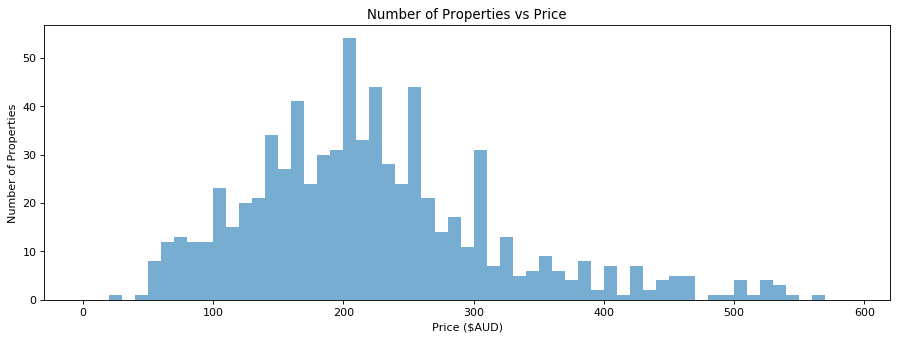

In [39]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=600, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')

#ax.grid(True)

# Filter to only 2 bedroom units:
tran_small_price1 = train_small.loc[train_small['bedrooms'] == 2]

# Filter where distance to Sydney between 100-150km
tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_dist_km'] >= 100) & (tran_small_price1['syd_dist_km'] <= 150)]

tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_brg'] == 'N')]


x = tran_small_price_local['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

In [40]:
tran_small_price_local.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,798.000000,798.0,798.000000,798.000000,768.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,1.418546,2.0,2.526316,3.913534,233.483073,-31.795106,152.067986,4.765664,42.439850,258.790727
std,0.530388,0.0,0.648275,0.359551,137.710805,2.372088,1.076115,11.459556,90.489403,282.049619
min,1.000000,2.0,0.000000,2.000000,23.000000,-33.908150,150.885570,0.000000,0.000000,9.000000
25%,1.000000,2.0,2.000000,4.000000,154.750000,-33.826066,151.221660,0.000000,14.000000,18.000000
50%,1.000000,2.0,2.000000,4.000000,212.500000,-33.404755,151.355285,0.000000,20.000000,68.000000
75%,2.000000,2.0,3.000000,4.000000,271.000000,-28.697841,153.545370,4.000000,21.000000,628.750000
max,3.000000,2.0,6.000000,4.000000,1568.000000,-28.166143,153.635440,126.000000,359.000000,685.000000


Text(0,0.5,'Count')

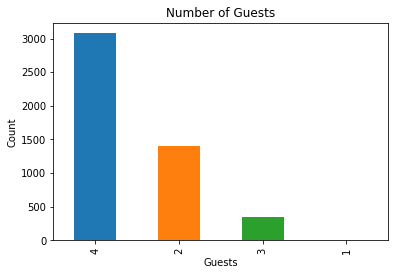

In [8]:
train_small['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [9]:
train_small['guests'].groupby(train_small['guests']).count()

guests
1       8
2    1410
3     349
4    3077
Name: guests, dtype: int64

In [10]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': train_small['init_price'],
    'Type': train_small['property_type'],
    'Bathrooms' : train_small['bathrooms'],
    'Beds' : train_small['beds']
})


#train_display.groupby('Type').hist()

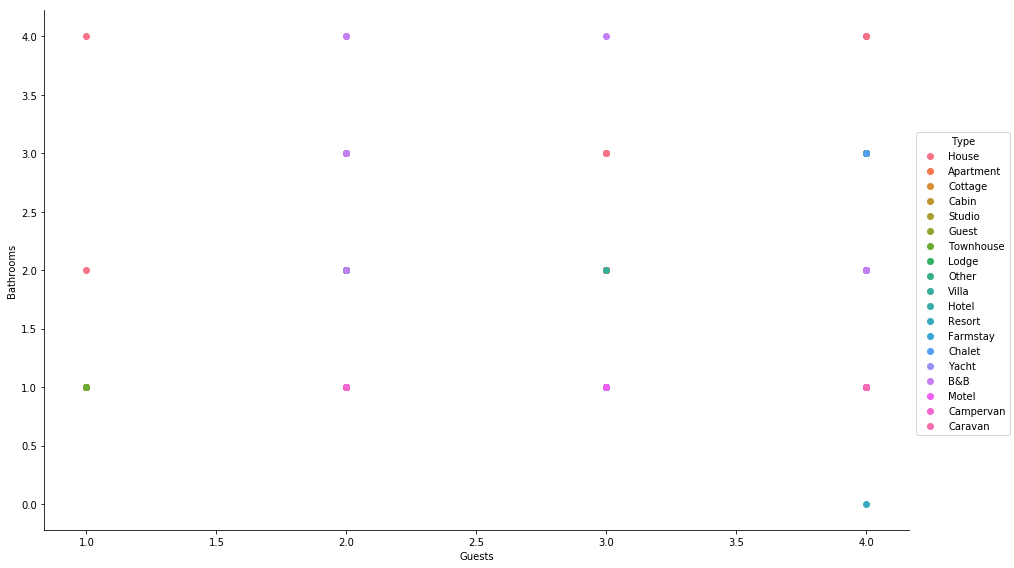

In [11]:
df = pd.DataFrame({
    'Guests': train_small['guests'],
    'Bathrooms': train_small['bathrooms'],
    'Type': train_small['property_type']
})

fg = sns.FacetGrid(data=df, hue='Type', aspect=1.61, size=8)
fg.map(plt.scatter, 'Guests', 'Bathrooms').add_legend()

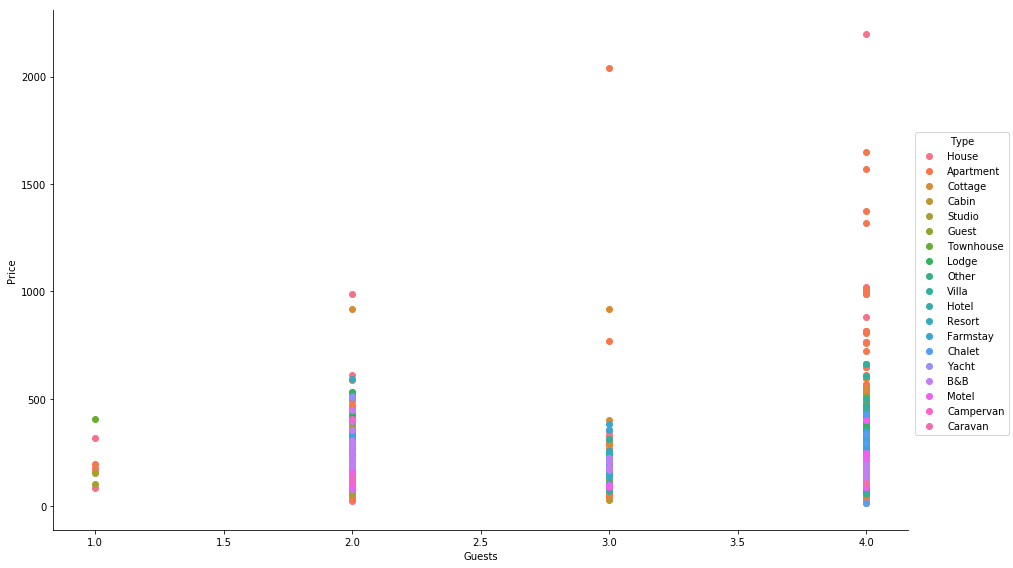

In [12]:
df = pd.DataFrame({
    'Guests': train_small['guests'],
    'Price': train_small['init_price'],
    'Type': train_small['property_type']
})

fg = sns.FacetGrid(data=df, hue='Type', aspect=1.61, size=8)
fg.map(plt.scatter, 'Guests', 'Price').add_legend()

Geocoded Data

In [ ]:
# Read the data file and display
geodata = pd.read_json('/Users/taj/GitHub/scraping/chrome_stayz_calendar/WebData/stayz_geocoded_test.json')

geodata = geodata.reset_index(drop=True)
geodata = geodata.set_index('property_id')

geodata.head()
